# Detecting Outliers with Cleanlab's outlier detection algorithm

This 5-minute quickstart tutorial shows how to detect potential outliers in image classification data. The dataset used is `cifar10` which contains 60,000 images. Each image belongs to 1 of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 

**Overview of what we'll do in this tutorial:**

- Load the [`cifar10`](https://www.cs.toronto.edu/~kriz/cifar.html) dataset and do some basic data pre-processing.
- Create `trainX` and `testX` such that `testX` contains extra categories
- Load pretrained model and extract feature embeddings of `trainX` and `testX`
- Compute outlier scores for each example using cleanlab's `get_outlier_scores` method and analyze results.

## 1. Install the required dependencies
You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install torch
!pip install cleanlab
...
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [2]:
# Package installation (hidden on docs website).
# If running on Colab, may want to use GPU (select: Runtime > Change runtime type > Hardware accelerator > GPU)

dependencies = ["cleanlab", "matplotlib", "torch", "pylab", "keras", "sklearn", "timm", ]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

Lets first set some seeds for reproducibility

In [69]:
import numpy as np
import torch
import warnings

# SEED = 123
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

## 2. Fetch and scale the Cifar10 dataset

After some basic preprocessing, we manually remove some categories from the training data, making them outliers in the test set. For this example we've chosen to remove all categories that are not an animal `[airplane, automobile, ship, truck]` from the training set `trainX`.

In [70]:
import matplotlib.pyplot as plt
from pylab import rcParams

from keras.datasets import cifar10, cifar100
from sklearn.model_selection import train_test_split

In [71]:
# Load cifar10 datasets
(trainX, trainy), (testX, testy) = cifar10.load_data()
trainX, _, trainy, _ = train_test_split(trainX, trainy, test_size=0.5, stratify=trainy, random_state=SEED) # only use 50% of each label

# Convert from integers to floats and normalize range 0-1
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0

# Manually remove non-animals out of the training dataset
animal_labels = [2,3,4,5,6,7]
animal_idxs = np.where(np.isin(trainy, animal_labels))[0] # find idx of animals
trainX = trainX[animal_idxs]
trainy = trainy[animal_idxs]

# Check the shapes of our training and test sets
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(15000, 32, 32, 3), y=(15000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


#### Lets visualize some of the training and test examples

In [72]:
txt_labels = {0: 'airplane', 
              1: 'automobile', 
              2: 'bird',
              3: 'cat', 
              4: 'deer', 
              5: 'dog', 
              6: 'frog', 
              7: 'horse', 
              8:'ship', 
              9:'truck'}

def plot_images(X,y):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        # define subplot
        ax = plt.subplot(3,5,i+1)
        ax.set_title(txt_labels[int(y[i])])
        # plot raw pixel data
        ax.imshow(X[i])
    # show the figure
    plt.show()

Observe how there are only animals left in the training set `trainX` below.

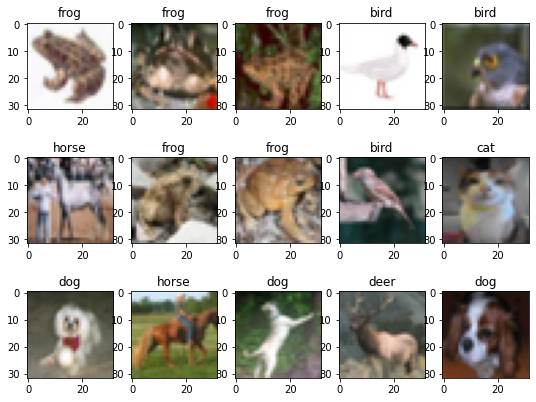

In [75]:
plot_images(trainX,trainy)

The test set on the other hand still visibily contains the non-animal images: ship, airplane, automobile, truck. If we consider `trainX` to be the representation of data, then these non-animal images in `testX` become outliers.

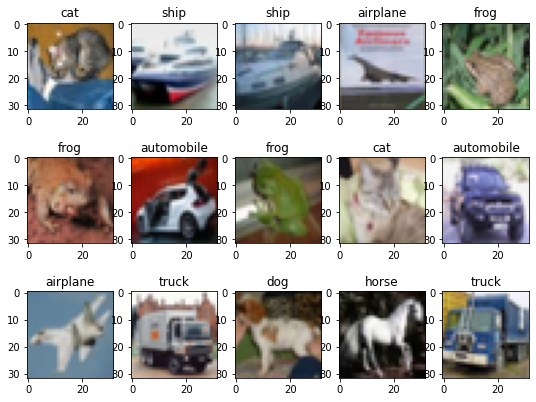

In [76]:
plot_images(testX,testy)

## 3. Import a model and embeddings
The model we are importing comes from `timm`, a deep-learning library collection of SOTA models and utilities.

The model itself is a `resnet50` but outlier detection can be done with any object capable of generating feature embeddings.

In [77]:
%%time
import timm

model = timm.create_model('resnet50', pretrained=True, num_classes=0) # download the model from timm
trainX_torch = torch.from_numpy(trainX.swapaxes(1,3)) # turn trainX into tensor and fix channel dimension
train_feature_embeddings = model(trainX_torch) # fit model to train images and get train embeddings
train_feature_embeddings = train_feature_embeddings.detach().numpy() # change type to numpy array
print(f'Pooled shape: {train_feature_embeddings.shape}')

Pooled shape: (15000, 2048)
CPU times: user 2min 25s, sys: 33.3 s, total: 2min 58s
Wall time: 1min 31s


In [78]:
%%time
model = timm.create_model('resnet50', pretrained=True, num_classes=0) # download the model from timm
testX_torch = torch.from_numpy(testX.swapaxes(1,3)) # turn trainX into tensor and fix channel dimension
test_feature_embeddings = model(testX_torch) # fit model to train images and get train embeddings
test_feature_embeddings = test_feature_embeddings.detach().numpy() # change type to numpy array
print(f'Pooled shape: {test_feature_embeddings.shape}')

Pooled shape: (10000, 2048)
CPU times: user 1min 37s, sys: 18.9 s, total: 1min 56s
Wall time: 58.2 s


## 4. Import cleanlab and find outliers in the dataset
We can use the `cleanlab` library to try and find the artificially added outlier examples `[airplanes, automobiles, trucks, boats]` in the test dataset. We can also check the training data to find any naturally occuring outlier examples in the dataset.

In [84]:
import cleanlab
from cleanlab.rank import get_outlier_scores
from sklearn.neighbors import NearestNeighbors # import KNN estimator

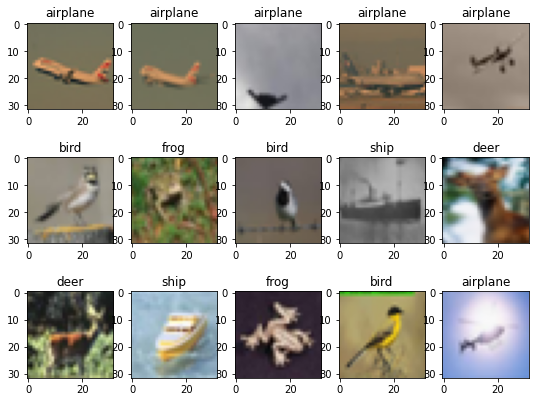

In [85]:
# import KNN estimator and fit it on the resnet50 feature embeddings
knn = NearestNeighbors(n_neighbors=10).fit(train_feature_embeddings)

# get outlier scores for the test feature embeddings
outlier_scores = get_outlier_scores(features=test_feature_embeddings, knn=knn, k=10)

# visualize top 15 outlier scores
top_outlier_idxs = (outlier_scores).argsort()[:15]
plot_images(testX[top_outlier_idxs],testy[top_outlier_idxs])

Notice how majority of the outliers belong to the holdout classes (airplane, automobile, ship). These feature representations are futher away in the model representation space than the training dataset representations. 

Just for fun, lets visualize what the NearestNeighbors algorithm considers the 15 least probable outliers in our test set. Notice there are a lot less images from the out of distribution classes here.

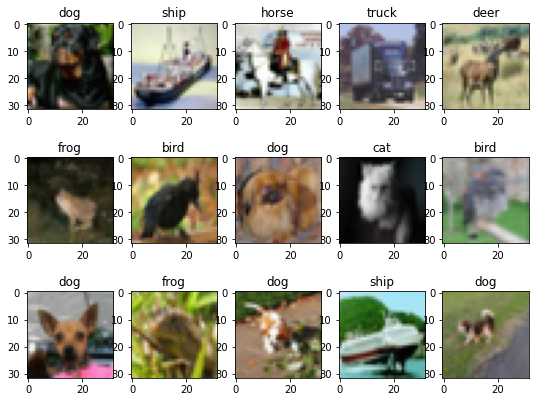

In [87]:
# visualize least probable 15 outlier scores
bottom_outlier_idxs = (-outlier_scores).argsort()[:15]
plot_images(testX[bottom_outlier_idxs],testy[bottom_outlier_idxs])

We can also compute the precision/recall of our algorithm for the examples. [Jonas is this important?]

In [14]:
from sklearn.metrics import precision_recall_curve
animal_labels = [2,3,4,5,6,7] # identify animal labels in the testing dataset
animal_idxs = np.where(np.isin(testy, animal_labels))[0] # find idx of animals
not_outlier = np.zeros(len(testy), dtype=bool) # is outlier
not_outlier[animal_idxs] = True
precision, recall, thresholds = precision_recall_curve(not_outlier, 1 - outlier_scores)

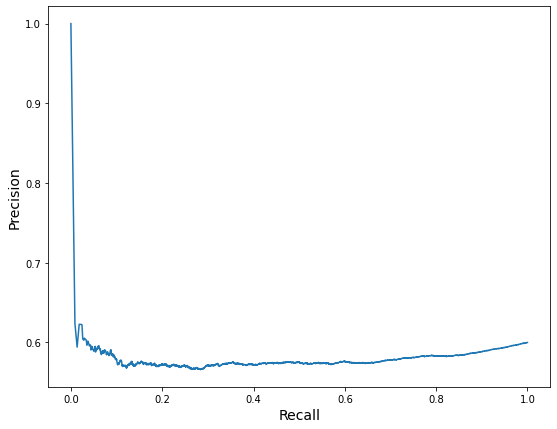

In [15]:
plt.plot(recall, precision)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.show()

### Finding naturally occuring outlier examples

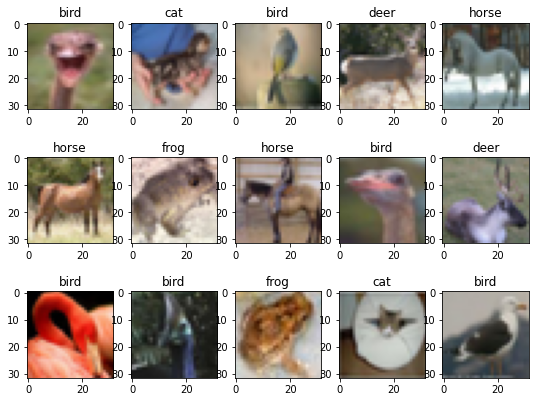

In [89]:
# get outlier scores for our train feature embeddings
outlier_scores = get_outlier_scores(features=train_feature_embeddings, k=10)

# visualize top 15 outlier scores
top_train_outlier_idxs = (outlier_scores).argsort()[:15]
plot_images(trainX[top_train_outlier_idxs],trainy[top_train_outlier_idxs])

Just for fun, lets see what our model considers the least likeley outliers in the training set! These examples are very homogeneous.

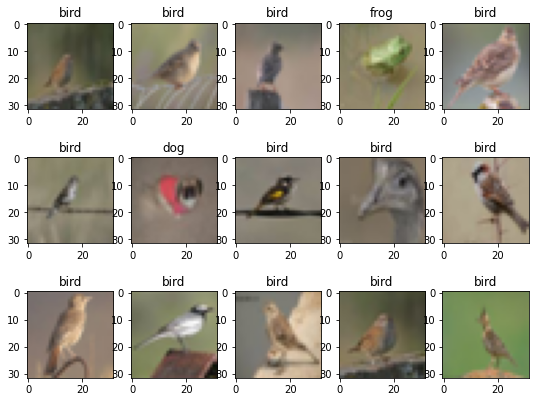

In [22]:
# visualize bottom 12 outlier scores on train set
top_outlier_idxs = (-outlier_scores).argsort()[:15]
plot_images(trainX[top_outlier_idxs],trainy[top_outlier_idxs])

## 4. Discovering outliers during training [remove for tutorial, add to example notebook]
What if our training data contained only a couple outliers? We can use Cleanlab to find these label issues!

**Lets add a couple ship outliers from the test set into our training dataset**

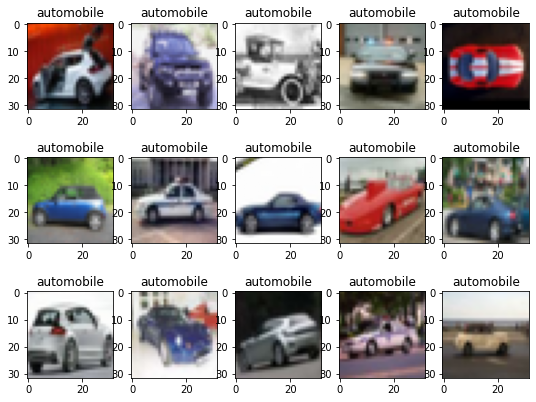

Train: X=(15000, 32, 32, 3), y=(15000, 1)
Train with outliers: X=(15025, 32, 32, 3), y=(15025, 1)


In [64]:
# Add a couple ship outliers from testX to the training dataset
num_outliers_to_add = 25

# Manually remove non-animals out of the training dataset
animal_labels = [2,3,4,5,6,7]
outlier_labels = [1] # outlier labels = [0,1,8,9]
outlier_idxs = np.where(np.isin(testy, outlier_labels))[0] # find idx of non-animals

# Select and visualize several examples from test set
testX_outliers = testX[outlier_idxs]
testy_outliers = testy[outlier_idxs]
plot_images(testX_outliers[:15],testy_outliers[:15])

# Now lets randomly assign non-outlier labels to our outlier data
testX_outliers = testX_outliers[:num_outliers_to_add]
trainy_outliers = np.random.choice(animal_labels, num_outliers_to_add, replace=True)[:,np.newaxis]

# Lets add the first x ships as outliers to the training data. You can change num_outliers_to_add to add more or less.
trainX_outliers = np.concatenate([trainX,testX_outliers])
trainy_outliers = np.concatenate([trainy,trainy_outliers])

# Check the shapes of our new training set contains outliers and test sets
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Train with outliers: X=%s, y=%s' % (trainX_outliers.shape, trainy_outliers.shape))

**Just like last time, get embeddings from a model**

In [65]:
%%time
model = timm.create_model('resnet50', pretrained=True, num_classes=0) # download the model from timm
trainX_outliers_torch = torch.from_numpy(trainX_outliers.swapaxes(1,3)) # turn trainX into tensor and fix channel dimension
outliers_feature_embeddings = model(trainX_outliers_torch) # fit model to train images and get train embeddings
outliers_feature_embeddings = outliers_feature_embeddings.detach().numpy() # change type to numpy array
print(f'Pooled shape: {outliers_feature_embeddings.shape}')

Pooled shape: (15025, 2048)
CPU times: user 2min 26s, sys: 30.5 s, total: 2min 57s
Wall time: 1min 29s


**Find naturally occuring examples and get outlier scores**

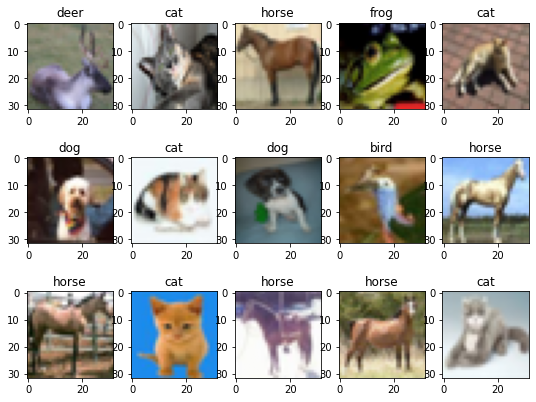

In [66]:
# get outlier scores for our train feature embeddings
outlier_scores = get_outlier_scores(features=outliers_feature_embeddings, k=10)

# visualize top 15 outlier scores
top_outlier_idxs = (outlier_scores).argsort()[:100]
true_labels = np.concatenate([trainy,testy_outliers]) # get real labels
plot_images(trainX_outliers[top_outlier_idxs],true_labels[top_outlier_idxs])

In [67]:
outlier_scores[top_outlier_idxs]

array([0.4619258 , 0.4625941 , 0.46388552, 0.46444422, 0.46521762,
       0.4653905 , 0.46568283, 0.46687764, 0.46730822, 0.46745735,
       0.46758464, 0.46793056, 0.46799052, 0.46974945, 0.47015074,
       0.4704626 , 0.47086245, 0.47097585, 0.47109026, 0.4713989 ,
       0.47156426, 0.47159892, 0.4716372 , 0.47179207, 0.4720718 ,
       0.47227758, 0.47233152, 0.47238505, 0.4723989 , 0.47240824,
       0.47256055, 0.47271138, 0.4727626 , 0.47287348, 0.472925  ,
       0.4730289 , 0.4734376 , 0.4734944 , 0.47357252, 0.4737946 ,
       0.47390828, 0.47391537, 0.47403717, 0.47409782, 0.47412014,
       0.47449884, 0.47466174, 0.4747245 , 0.4748799 , 0.47495   ,
       0.47522116, 0.4752277 , 0.4753206 , 0.47533208, 0.47540084,
       0.47550267, 0.4755575 , 0.4756424 , 0.47604528, 0.47628248,
       0.47634175, 0.47637412, 0.4764196 , 0.47642353, 0.47655314,
       0.4766599 , 0.4766818 , 0.4766961 , 0.47675198, 0.47687116,
       0.47716448, 0.47719464, 0.47719792, 0.4772052 , 0.47726

In [68]:
outlier_scores[-25:]

array([0.59901136, 0.5064753 , 0.5873347 , 0.55515856, 0.5118187 ,
       0.5322126 , 0.52170265, 0.51417696, 0.5693949 , 0.50101286,
       0.5068356 , 0.5849657 , 0.52633315, 0.49230433, 0.7845379 ,
       0.57373476, 0.5047395 , 0.509668  , 0.52456117, 0.5009604 ,
       0.48665628, 0.5025502 , 0.5310244 , 0.52664876, 0.523278  ],
      dtype=float32)

In [91]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

top_outlier_idxs_test = [4102, 9193, 6549, 5146, 4294, 3281, 8698, 1802, 2254, 8886, 4734,408,  770, 2513, 2909]
bottom_outlier_idxs_test = [6165, 5020, 8466, 1914, 4322, 5113, 6697, 7608,  273, 7802, 7795,4325,  910, 6125, 9815]
top_outlier_idxs_train = [ 8083,   370,  8931,  5719,  8245,  2568, 12055,  9209,  3905,9630, 12033, 11411,  8624,  2162, 10587]

if not all(x in top_outlier_idxs for x in top_outlier_idxs_test):
    raise Exception("Some highlighted examples are missing from top outliers in test set.")

if not all(x in bottom_outlier_idxs for x in bottom_outlier_idxs_test):
    raise Exception("Some highlighted examples are missing from bottom test set outliers.")

if not all(x in top_train_outlier_idxs for x in top_outlier_idxs_train):
    raise Exception("Some highlighted examples are missing from finding naturally occuring outliers.")
